In [1]:
import os
import numpy as np
import tensorflow as tf
from pathlib import Path
from tensorflow import keras
from inception_model import InceptionV3
from sklearn.model_selection import train_test_split

#### load datasets

In [ ]:
# Define the data directory containing all images organized by class
data_dir = Path(r'Datasets/PV01')

def load_data_from_directory(directory, img_size=(299, 299)):
    images = []
    labels = []
    class_names = []
    
    for class_idx, class_dir in enumerate(sorted(os.listdir(directory))):
        class_path = os.path.join(directory, class_dir)
        if not os.path.isdir(class_path):
            continue
        
        class_names.append(class_dir)
        
        for img_file in os.listdir(class_path):
            if img_file.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                img_path = os.path.join(class_path, img_file)
                try:
                    img = keras.preprocessing.image.load_img(img_path, target_size=img_size)
                    img_array = keras.preprocessing.image.img_to_array(img)
                    images.append(img_array)
                    labels.append(class_idx)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
    
    return np.array(images), np.array(labels), class_names


# Load all data from the Datasets directory
try:
    all_images, all_labels, class_names = load_data_from_directory(data_dir)
    print(f"Loaded all data: {all_images.shape}")
    print(f"Classes: {class_names}\n")
except Exception as e:
    print(f"Error loading data: {e}")
    breakpoint()

# Split data: 70% train, 15% validation, 15% test
train_images, temp_images, train_labels, temp_labels = train_test_split(
    all_images, all_labels, test_size=0.3, random_state=42, stratify=all_labels
)

validation_images, test_images, validation_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

print(f"Train images shape: {train_images.shape}")
print(f"Validation images shape: {validation_images.shape}")
print(f"Test images shape: {test_images.shape}")

Loaded all data: (1290, 299, 299, 3)
Classes: ['PV01_Rooftop_Brick', 'PV01_Rooftop_FlatConcrete', 'PV01_Rooftop_SteelTile']

Train images shape: (903, 299, 299, 3)
Validation images shape: (193, 299, 299, 3)
Test images shape: (194, 299, 299, 3)
Train images shape: (903, 299, 299, 3)
Validation images shape: (193, 299, 299, 3)
Test images shape: (194, 299, 299, 3)


### Split into Training, Validation, and Test Sets

The data is split from a single dataset directory using stratified split:
- **Training set**: 70% of data (used for model training)
- **Validation set**: 15% of data (used for model validation during training)
- **Test set**: 15% of data (used for final model evaluation)

The stratified split ensures each class is represented proportionally in all three sets.

In [3]:
# Create TensorFlow datasets from the pre-split data
print(f"Creating TensorFlow datasets...")
print(f"Training samples: {len(train_images)}")
print(f"Validation samples: {len(validation_images)}")
print(f"Test samples: {len(test_images)}\n")

# Building tensorflow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

Creating TensorFlow datasets...
Training samples: 903
Validation samples: 193
Test samples: 194



In [4]:
def process_images(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    image = tf.image.resize(image, (299, 299))
    return image, label

train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
validation_ds_size = tf.data.experimental.cardinality(validation_ds).numpy()

print(f"Dataset sizes:")
print(f"Training batches: {train_ds_size}")
print(f"Validation batches: {validation_ds_size}")
print(f"Test batches: {test_ds_size}\n")

train_ds = (train_ds
            .map(process_images)
            .shuffle(buffer_size=train_ds_size)
            .batch(batch_size=32, drop_remainder=True))
test_ds = (test_ds
           .map(process_images)
           .shuffle(buffer_size=test_ds_size)
           .batch(batch_size=32, drop_remainder=True))
validation_ds = (validation_ds
                 .map(process_images)
                 .shuffle(buffer_size=validation_ds_size)
                 .batch(batch_size=32, drop_remainder=True))

Dataset sizes:
Training batches: 903
Validation batches: 193
Test batches: 194



In [5]:
# Building the Inception V3 Model Architecture
model = InceptionV3()

# Compiling the Model with single output
model.compile(
    optimizer='adam',
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

# Checking Model Summary
model.summary()

Model: "Inception-V3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 150, 150,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 150, 150,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 150, 150,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 150, 150,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 150, 150,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 150, 150,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 150, 150,  │     18,496 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 150, 150,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 150, 150,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 74, 74,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 74, 74,    │      5,200 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 74, 74,    │        320 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 74, 74,    │    138,432 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 74, 74,    │        768 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 74, 74,    │          0 │ batch_normalizat

 Total params: 27,935,112 (106.56 MB)

 Trainable params: 27,900,680 (106.43 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [6]:
# Model Training
print("Starting model training...")
history = model.fit(
    train_ds,
    epochs=5,
    validation_data=validation_ds,
    validation_freq=1
)

print("\nTraining completed!")

Starting model training...
Epoch 1/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 215s 7s/step - accuracy: 0.6194 - loss: 1.2759 - val_accuracy: 0.5833 - val_loss: 46.3192
Epoch 2/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 215s 7s/step - accuracy: 0.6194 - loss: 1.2759 - val_accuracy: 0.5833 - val_loss: 46.3192
Epoch 2/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 195s 7s/step - accuracy: 0.7690 - loss: 0.6005 - val_accuracy: 0.6406 - val_loss: 16.0874
Epoch 3/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 195s 7s/step - accuracy: 0.7690 - loss: 0.6005 - val_accuracy: 0.6406 - val_loss: 16.0874
Epoch 3/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 195s 7s/step - accuracy: 0.7355 - loss: 0.6416 - val_accuracy: 0.1823 - val_loss: 1.3196
Epoch 4/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 195s 7s/step - accuracy: 0.7355 - loss: 0.6416 - val_accuracy: 0.1823 - val_loss: 1.3196
Epoch 4/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 198s 7s/step - accuracy: 0.7266 - loss: 0.7396 - val_accuracy: 0.7292 - val_loss: 0.6479
Epoch 5/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 198s 7s/step - accuracy: 0.7266 - loss: 0.7396 - v

### Model Evaluation and Results

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate on test set
print("Evaluating model on test set...")
test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)
print(f"\nTest Set Results:")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")

# Get predictions on raw test data (before batching) to avoid drop_remainder issues
# Process the test images with the same preprocessing
def preprocess_images_for_prediction(images):
    processed = []
    for img in images:
        img = tf.image.per_image_standardization(img)
        img = tf.image.resize(img, (299, 299))
        processed.append(img)
    return np.array(processed)

test_images_processed = preprocess_images_for_prediction(test_images)
test_predictions = model.predict(test_images_processed, verbose=0)
test_pred_labels = np.argmax(test_predictions, axis=1)

# Calculate metrics
print(f"\n{'='*60}")
print("Classification Report:")
print(f"{'='*60}")
print(classification_report(test_labels, test_pred_labels, target_names=class_names))

# Accuracy on validation set
val_loss, val_accuracy = model.evaluate(validation_ds, verbose=0)
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Evaluating model on test set...

Test Set Results:
Loss: 49.3223
Accuracy: 0.6458

Test Set Results:
Loss: 49.3223
Accuracy: 0.6458

Classification Report:
                           precision    recall  f1-score   support

       PV01_Rooftop_Brick       1.00      0.02      0.05        42
PV01_Rooftop_FlatConcrete       0.65      1.00      0.78       124
   PV01_Rooftop_SteelTile       1.00      0.04      0.07        28

                 accuracy                           0.65       194
                macro avg       0.88      0.35      0.30       194
             weighted avg       0.77      0.65      0.52       194


Classification Report:
                           precision    recall  f1-score   support

       PV01_Rooftop_Brick       1.00      0.02      0.05        42
PV01_Rooftop_FlatConcrete       0.65      1.00      0.78       124
   PV01_Rooftop_SteelTile       1.00      0.04      0.07        28

                 accuracy                           0.65       194
           

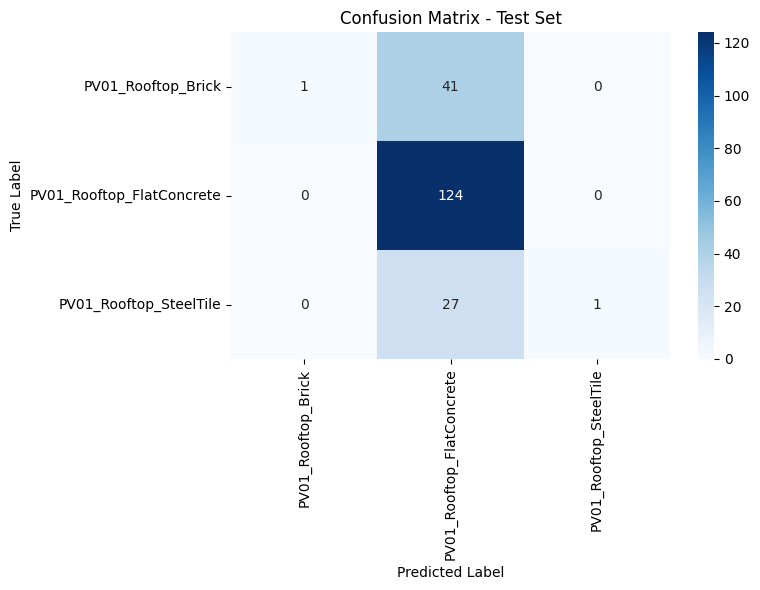


Confusion Matrix:


In [ ]:
# Confusion Matrix
cm = confusion_matrix(test_labels, test_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

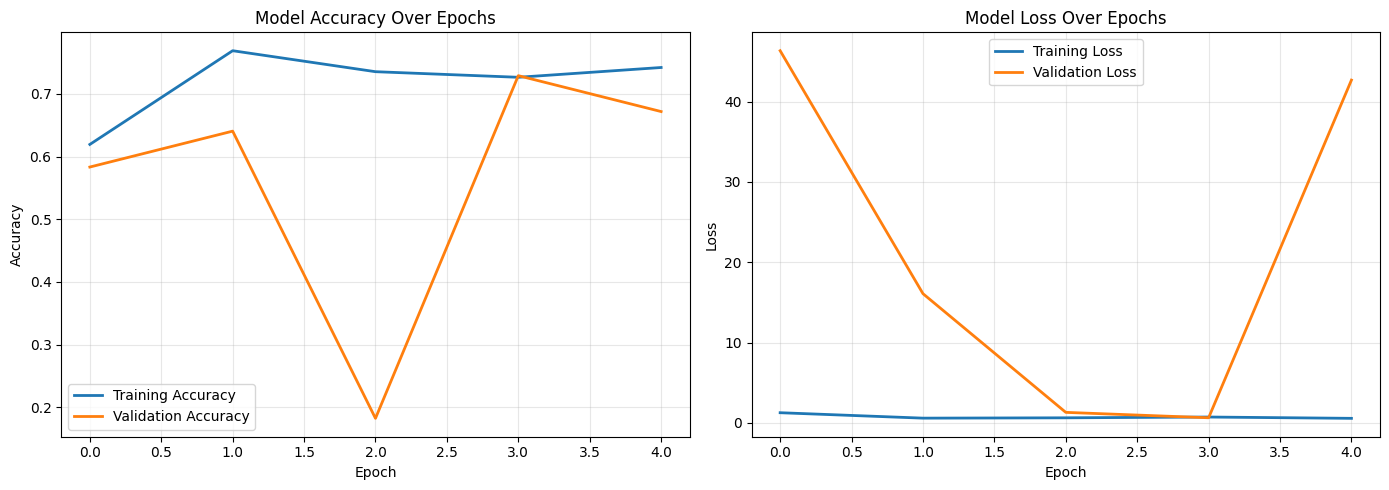


TRAINING SUMMARY
Final Training Accuracy: 0.7422
Final Validation Accuracy: 0.6719
Final Training Loss: 0.5765
Final Validation Loss: 42.6637
Best Validation Accuracy: 0.7292


In [11]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy Over Epochs')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Loss Over Epochs')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary of results
print(f"\n{'='*60}")
print("TRAINING SUMMARY")
print(f"{'='*60}")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"{'='*60}")